In [1]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from gensim.models import Word2Vec
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import cohen_kappa_score

Using TensorFlow backend.


**Preparing Dataset**

In [2]:
df = pd.read_csv("Dataset/training_set_rel3.tsv", sep='\t', encoding='ISO-8859-1');
df.dropna(axis=1,inplace=True)
df.drop(columns=['domain1_score','rater1_domain1','rater2_domain1'],inplace=True,axis=1)
df.head()
temp = pd.read_csv("Processed_data.csv")
temp.drop("Unnamed: 0",inplace=True,axis=1)

In [3]:
df['domain1_score']=temp['final_score']
df.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",6
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",7
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",5
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",8
4,5,1,"Dear @LOCATION1, I know having computers has a...",6


In [4]:
df['essay'][0]

"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the econom

In [5]:
temp.head(4)

,essay_id,essay_set,essay,final_score,clean_essay,char_count,word_count,sent_count,avg_word_len,spell_err_count,noun_count,adj_count,verb_count,adv_count
0,1,1,"Dear local newspaper, I think effects computer...",6,Dear local newspaper I think effects computer...,1441,344,16,4.188953,11,76,75,18,24
1,2,1,Dear I believe that using computers will benef...,7,Dear I believe using computers benefit us many...,1765,413,17,4.273608,21,98,84,20,19
2,3,1,"Dear, More and more people use computers, but ...",5,Dear More people use computers everyone agre...,1185,276,14,4.293478,5,76,51,20,16
3,4,1,"Dear Local Newspaper, I have found that many e...",8,Dear Local Newspaper I found many experts say...,2284,490,26,4.661224,31,142,96,39,29


In [6]:
#Make Dataset
y = df['domain1_score']
df.drop('domain1_score',inplace=True,axis=1)
X=df

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
X_train.shape

(9083, 3)

**PREPROCESSING**

In [9]:
train_e = X_train['essay'].tolist()
test_e = X_test['essay'].tolist()

In [10]:
train_sents=[]
test_sents=[]

stop_words = set(stopwords.words('english')) 
def sent2word(x):
    x=re.sub("[^A-Za-z]"," ",x)
    x.lower()
    filtered_sentence = [] 
    words=x.split()
    for w in words:
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

def essay2word(essay):
    essay = essay.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw = tokenizer.tokenize(essay)
    final_words=[]
    for i in raw:
        if(len(i)>0):
            final_words.append(sent2word(i))
    return final_words

for i in train_e:
    train_sents+=essay2word(i)

for i in test_e:
    test_sents+=essay2word(i)

In [11]:
len(train_sents)

115941

In [12]:
train_sents[0]

['It',
 'first',
 'day',
 'high',
 'school',
 'gut',
 'full',
 'butterflies',
 'make',
 'want',
 'run',
 'bathrooms',
 'hide',
 'world']

**Preparing WORD2VEC and LSTM Model**

In [13]:
def get_model():
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(128, recurrent_dropout=0.4, return_sequences = True))
    model.add(Dropout(0.3))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()
    return model

In [14]:
#Training Word2Vec model
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

model = Word2Vec(train_sents, 
                 workers=num_workers, 
                 size=num_features, 
                 min_count = min_word_count, 
                 window = context, 
                 sample = downsampling)

model.init_sims(replace=True)
model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

In [15]:
def makeVec(words, model, num_features):
    vec = np.zeros((num_features,),dtype="float32")
    noOfWords = 0.
    index2word_set = set(model.wv.index2word)
    for i in words:
        if i in index2word_set:
            noOfWords += 1
            vec = np.add(vec,model[i])        
    vec = np.divide(vec,noOfWords)
    return vec


def getVecs(essays, model, num_features):
    c=0
    essay_vecs = np.zeros((len(essays),num_features),dtype="float32")
    for i in essays:
        essay_vecs[c] = makeVec(i, model, num_features)
        c+=1
    return essay_vecs


clean_train=[]
for i in train_e:
    clean_train.append(sent2word(i))
training_vectors = getVecs(clean_train, model, num_features)

clean_test=[] 

for i in test_e:
    clean_test.append(sent2word(i))
testing_vectors = getVecs(clean_test, model, num_features)

/Users/satin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/Users/satin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [16]:
training_vectors.shape

(9083, 300)

In [17]:
training_vectors = np.array(training_vectors)
testing_vectors = np.array(testing_vectors)

# Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
training_vectors = np.reshape(training_vectors, (training_vectors.shape[0], 1, training_vectors.shape[1]))
testing_vectors = np.reshape(testing_vectors, (testing_vectors.shape[0], 1, testing_vectors.shape[1]))
lstm_model = get_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 300)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 128)            219648    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [18]:
training_vectors.shape

(9083, 1, 300)


**TRAINING AND PREDICTION**







In [19]:
lstm_model.fit(training_vectors, y_train, batch_size=64, epochs=150)

Epoch 1/150
9083/9083 [==============================] - 11s 1ms/step - loss: 8.7426 - mae: 2.2763
Epoch 2/150
9083/9083 [==============================] - 6s 689us/step - loss: 5.2545 - mae: 1.8128
Epoch 3/150
9083/9083 [==============================] - 6s 702us/step - loss: 5.0300 - mae: 1.7630
Epoch 4/150
9083/9083 [==============================] - 7s 724us/step - loss: 4.9506 - mae: 1.7509
Epoch 5/150
9083/9083 [==============================] - 6s 710us/step - loss: 4.8757 - mae: 1.7418
Epoch 6/150
9083/9083 [==============================] - 7s 732us/step - loss: 4.9107 - mae: 1.7411
Epoch 7/150
9083/9083 [==============================] - 7s 745us/step - loss: 4.7872 - mae: 1.7242
Epoch 8/150
9083/9083 [==============================] - 7s 718us/step - loss: 4.8070 - mae: 1.7269
Epoch 9/150
9083/9083 [==============================] - 7s 727us/step - loss: 4.8180 - mae: 1.7244
Epoch 10/150
9083/9083 [==============================] - 7s 730us/step - loss: 4.7152 - mae: 1.7015


9083/9083 [==============================] - 7s 754us/step - loss: 3.5437 - mae: 1.4625
Epoch 83/150
9083/9083 [==============================] - 7s 741us/step - loss: 3.4909 - mae: 1.4455
Epoch 84/150
9083/9083 [==============================] - 7s 763us/step - loss: 3.5297 - mae: 1.4571
Epoch 85/150
9083/9083 [==============================] - 7s 767us/step - loss: 3.5105 - mae: 1.4572 0s - loss: 3.5081 - mae: 1.45
Epoch 86/150
9083/9083 [==============================] - 7s 761us/step - loss: 3.5006 - mae: 1.4527
Epoch 87/150
9083/9083 [==============================] - 7s 773us/step - loss: 3.4893 - mae: 1.4541
Epoch 88/150
9083/9083 [==============================] - 7s 784us/step - loss: 3.4428 - mae: 1.4397
Epoch 89/150
9083/9083 [==============================] - 7s 778us/step - loss: 3.4662 - mae: 1.4457
Epoch 90/150
9083/9083 [==============================] - 7s 795us/step - loss: 3.4185 - mae: 1.4369
Epoch 91/150
9083/9083 [==============================] - 7s 796us/step - 

In [20]:
lstm_model.save('final_lstm.h5')
y_pred = lstm_model.predict(testing_vectors)
y_pred = np.around(y_pred)
y_pred

array([[3.],
       [5.],
       [7.],
       ...,
       [8.],
       [7.],
       [8.]], dtype=float32)

In [21]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error

In [43]:
y_pred = lstm_model.predict(testing_vectors)
y_pred = np.around(y_pred)

In [51]:
result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
print("Kappa Score: {}".format(result))

Kappa Score: 0.6353759525826073


In [52]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

Mean squared error: 3.25


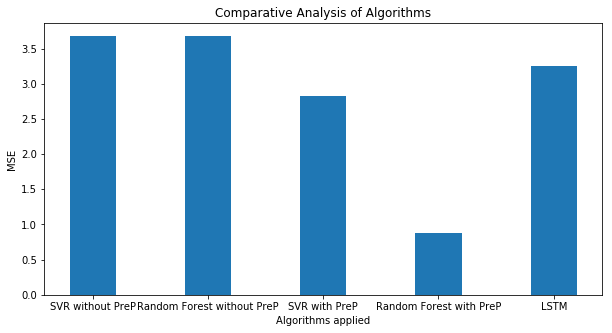

In [5]:
import matplotlib.pyplot as plt  
%matplotlib inline

data = {'SVR without PreP':3.68, 'Random Forest without PreP':3.68, 'SVR with PreP':2.83,  
        'Random Forest with PreP':0.88, 'LSTM': 3.25} 
algos = list(data.keys()) 
values = list(data.values()) 
   
fig = plt.figure(figsize = (10, 5)) 
plt.bar(algos, values, width = 0.4) 
  
plt.xlabel("Algorithms applied") 
plt.ylabel("MSE") 
plt.title("Comparative Analysis of Algorithms") 
plt.show() 